In [1]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.cbook as cbook
import matplotlib.ticker as ticker

from matplotlib.backends.backend_pdf import PdfPages


# Data Import 

In [2]:
df = pd.read_excel('D:\\backup\\Corona\\Global_new_cases_cntry.xlsx', sheet_name='data')
df_conti = pd.read_excel('D:\\backup\\Corona\\continent_clean.xlsx')
df_rec = pd.read_excel('D:\\backup\\Corona\\Global_recovered_cases.xlsx', sheet_name='data')
df_pop = pd.read_excel('D:\\backup\\Corona\\world_population.xlsx')

In [3]:
#Format date columns 
df['date'] = pd.to_datetime(df['Date'], format= '%Y-%m-%d', errors='ignore')
df_rec['date'] = pd.to_datetime(df_rec['Date'], format= '%Y-%m-%d', errors='ignore')

#aggrigate region to country 
lcountry = ['China','Canada','France','Australia','United Kingdom','Netherlands','Denmark'] 
#df1= pd.DataFrame()

for i in lcountry: 
    
    filter_col = [col for col in df if col.startswith(i)]
    df[i] = df[filter_col].sum(axis=1) 
    df.drop(filter_col[1:], axis=1,inplace=True)

    filter_col = [col for col in df_rec if col.startswith(i)]
    df_rec[i] = df_rec[filter_col].sum(axis=1) 
    df_rec.drop(filter_col[1:], axis=1,inplace=True)

In [4]:
df_rec.shape

(68, 178)

In [5]:
leme = df_conti[(df_conti.continentname == 'Europe')].country.tolist()
lcountry = ['Germany', 'Italy', 'Spain', 'United Kingdom', 'France', 'US']

leme.append('date')
lfcountry = leme.copy() 
lfcountry.append('US')

In [6]:
df_eme = df.filter(items= leme)
df_eme['EME'] = df_eme.sum(axis=1)
df_eme['infection_r'] = (df_eme.EME.shift(periods=-1) - df_eme.EME)/df_eme.EME
df_eme['infection_r_ma'] = (df_eme.infection_r.rolling(7, min_periods= 4).mean())


df_rec1 = df_rec.filter(items= leme)
df_rec1['emerec'] = df_rec1.sum(axis=1)
df_eme = df_eme.merge(df_rec1[['date', 'emerec']], how= 'left' , on = 'date')
df_eme['recoveryperday'] = (df_eme.emerec - df_eme.emerec.shift(periods=1))
df_eme['recovery_r'] = df_eme.emerec/df_eme.EME
df_eme['recovery_r_ma'] = (df_eme.recovery_r.rolling(7, min_periods= 4).mean())


In [7]:
df_pop_eme = df_pop.merge(df_conti[['country', 'continentcode']], left_on= 'Country', right_on= 'country' )

In [8]:
eme_pop= df_pop_eme[(df_pop_eme.continentcode == 'EU')].Population.sum()

In [9]:
continent.columns

NameError: name 'continent' is not defined

# Current Trend

(0, 652.6113)

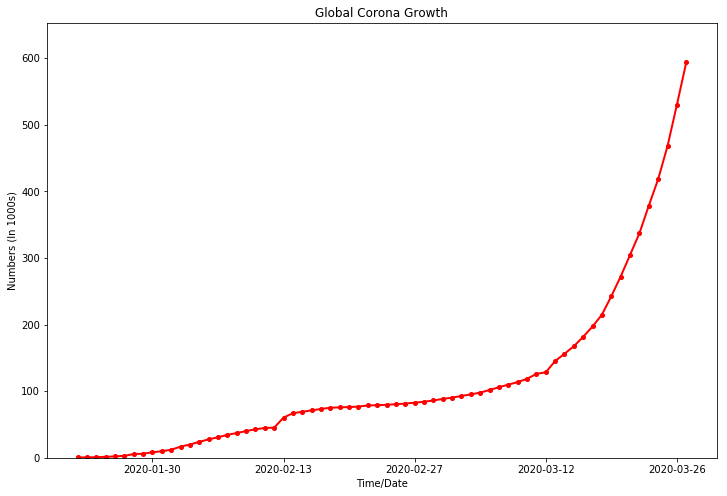

In [373]:
adj = 1000
plt.figure(figsize=(12,8))
fig = plt.plot(df.date, df.globalcases/adj, color='red', marker='o', linewidth=2, markersize=4)
plt.title('Global Corona Growth')
plt.xlabel('Time/Date')
plt.ylabel('Numbers (In 1000s)')
plt.ylim(0,df.globalcases.max()*1.1/adj)

# Last one month 

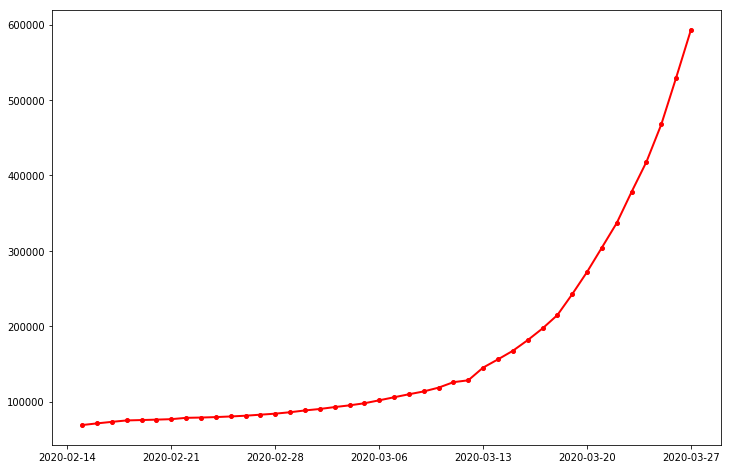

In [7]:
plt.figure(figsize=(12,8))
fig = plt.plot(df[(df.date > '2020-02-14')][['date']], df[(df.date > '2020-02-14')][['globalcases']], color='red', marker='o', linewidth=2, markersize=4)

In [8]:
df[(df.date > '2020-02-14')][df.columns[-8:]].head()

,globalcases,except_china,casesperday,newcaserate,recovery,recoveryperday,recoveryrate,date
24,69030,617,2145,0.032070,9395,1337,0.019368,2020-02-15
25,71224,711,2194,0.031783,10865,1470,0.020639,2020-02-16
26,73258,824,2034,0.028558,12583,1718,0.023451,2020-02-17
27,75136,925,1878,0.025635,14352,1769,0.023544,2020-02-18
28,75639,1020,503,0.006695,16121,1769,0.023387,2020-02-19


# Epidemic Model EME

In [10]:
#Configuration

from_date = '2020-03-26'
qurantine_fraction = 0.5

# Total population, N.
N = eme_pop * (1-qurantine_fraction)



ind = df_eme[(df_eme.date == from_date)].index.values.tolist()[0]
df_eme[(df_eme.date == from_date)]

from_date = datetime.strptime(from_date, '%Y-%m-%d') 

# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = df_eme[(df_eme.date == from_date)].at[ind,'EME'],  df_eme[(df_eme.date == from_date)].at[ind,'emerec']

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = df_eme[(df_eme.date == from_date)].at[ind,'infection_r_ma'],  df_eme[(df_eme.date == from_date)].at[ind,'recovery_r']
#gamma= .04
print('Infection Rate = ', beta    , '     Recovery Rrate = ', gamma)

Infection Rate =  0.14040626291954544      Recovery Rrate =  0.10308140362326135


Reproduction number(R0) =  1.36


<Figure size 432x288 with 0 Axes>

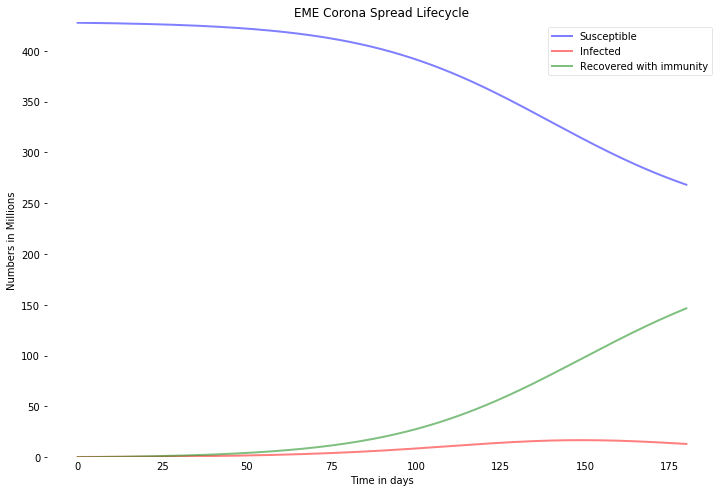

In [11]:

print('Reproduction number(R0) = ', round(beta/gamma,2))
adj = 1000000

# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

# A grid of time points (in days)
t = np.linspace(0, 180,180)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt


# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(t, S/adj, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/adj, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/adj, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time in days')
ax.set_ylabel('Numbers in Millions')
ax.set_title('EME Corona Spread Lifecycle')
ax.set_ylim(0,N/adj)
#ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)

for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [12]:
df_eme[['date', 'EME']].tail(10)

,date,EME
56,2020-03-18,90755
57,2020-03-19,109295
58,2020-03-20,129996
59,2020-03-21,151830
60,2020-03-22,171572
61,2020-03-23,197402
62,2020-03-24,221463
63,2020-03-25,251772
64,2020-03-26,288083
65,2020-03-27,325920


In [13]:
res = pd.DataFrame([t, S , I ,R]).T
res.columns = ['Days','Susceptible', 'Infected','Recovered' ]
res[['Susceptible','Infected','Recovered']] = res[['Susceptible','Infected','Recovered']].astype('int32')
res.Days = res.Days.round()
#dt = datetime.strptime('21-03-2020', "%d-%m-%Y")
res['Date'] = res.apply(lambda row : from_date + pd.DateOffset(days = row.Days), axis =1 )
res = res[['Date','Infected','Recovered','Susceptible']]
res.head(15)

,Date,Infected,Recovered,Susceptible
0,2020-03-26,288083,29696,427699653
1,2020-03-27,299067,60123,427658240
2,2020-03-28,310467,91711,427615253
3,2020-03-29,322296,124502,427570632
4,2020-03-30,334571,158543,427524317
5,2020-03-31,347308,193880,427476243
6,2020-04-01,360524,230562,427426345
7,2020-04-02,374237,268639,427374555
8,2020-04-03,388464,308164,427320802
9,2020-04-04,403225,349192,427265014


(0, 0.5545474)

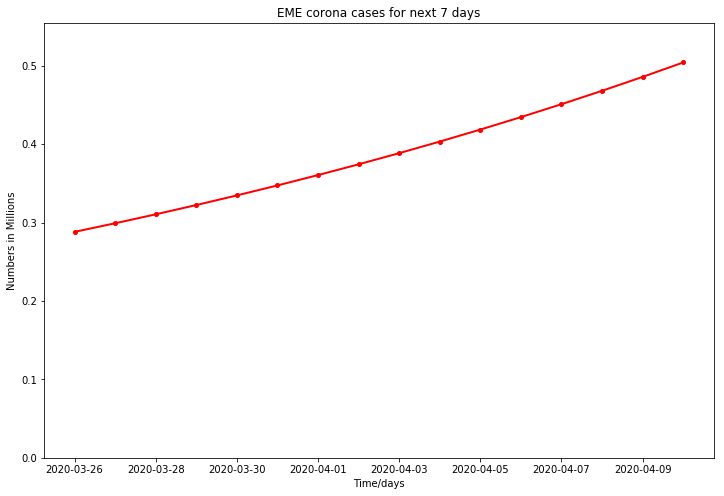

In [14]:
adj = 1000000
res1 = res.head(16)

plt.figure(figsize=(12,8))
plt.title('EME corona cases for next 7 days')
fig = plt.plot(res1.Date,res1.Infected/adj, color='red', marker='o', linewidth=2, markersize=4)
plt.xlabel('Time/days')
plt.ylabel('Numbers in Millions')
plt.ylim(0,res1.Infected.max()*1.1/adj)

(0, 0.9304196000000001)

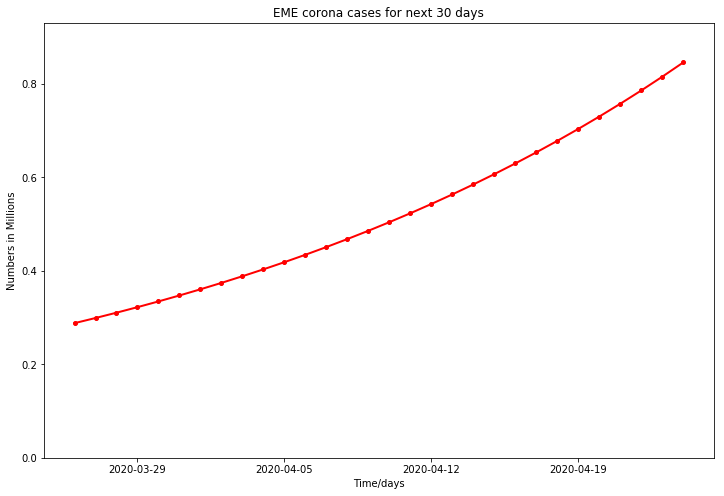

In [15]:
adj = 1000000
res1 = res.head(30)

plt.figure(figsize=(12,8))
plt.title('EME corona cases for next 30 days')
fig = plt.plot(res1.Date,res1.Infected/adj, color='red', marker='o', linewidth=2, markersize=4)
plt.xlabel('Time/days')
plt.ylabel('Numbers in Millions')
plt.ylim(0,res1.Infected.max()*1.1/adj)

(0, 0.9304196000000001)

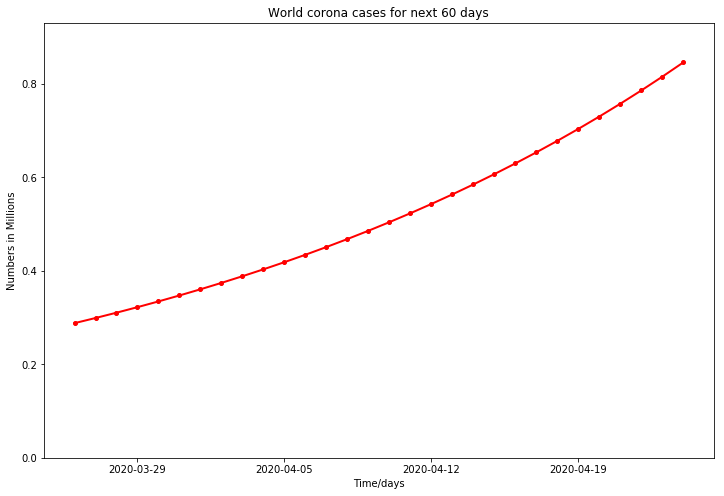

In [16]:
res2 = res.head(30)

plt.figure(figsize=(12,8))
plt.title('World corona cases for next 60 days')
fig = plt.plot(res2.Date,res2.Infected/adj, color='red', marker='o', linewidth=2, markersize=4)
plt.xlabel('Time/days')
plt.ylabel('Numbers in Millions')
plt.ylim(0,res2.Infected.max()*1.1/adj)

# Epidemic Model by country

In [47]:
lcountry = ['Germany', 'Italy', 'Spain', 'United Kingdom', 'France', 'US']
lcountry.append('date')
df_eme_t = df.filter(items= lcountry)

df_rec2 = df_rec.filter(items= lcountry)
df_rec2 = df_rec2.add_prefix('rec_')

df_eme_t = df_eme_t.merge(df_rec2, how= 'left' , left_on= 'date', right_on= 'rec_date')


df_eme_t['Germany_infection_r'] = (df_eme_t.Germany.shift(periods=-1) - df_eme_t.Germany)/df_eme_t.Germany
df_eme_t['Germany_infection_r_ma'] = (df_eme_t.Germany_infection_r.rolling(30, min_periods= 4).mean())
#df_eme_t['Germany_recoveryperday'] = (df_eme_t.rec_Germany - df_eme_t.rec_Germany.shift(periods=1))
df_eme_t['Germany_recovery_r'] = df_eme_t.rec_Germany/df_eme_t.Germany 
df_eme_t['Germany_recovery_r_ma'] = (df_eme_t.Germany_recovery_r.rolling(30, min_periods= 4).mean())


In [48]:
c_list = ['Germany', 'Italy', 'Spain', 'United Kingdom', 'France']
for i in c_list: 
    print(i)
    rec_col_name = 'rec_'+i
    inf_col_name = i+'_infection_r'
    inf_ma_col_name = i+'_infection_r_ma'
    rec_rate_col_name = i+'_recovery_r'
    rec_ma_name = i+'_recovery_r_ma'
    
    #print()
    
    df_eme_t[inf_col_name] = (df_eme_t[i].shift(periods=-1) - df_eme_t[i])/df_eme_t[i]
    df_eme_t[inf_ma_col_name] = (df_eme_t[inf_col_name].rolling(7, min_periods= 4).mean())
    
    #df_eme_t['Germany_recoveryperday'] = (df_eme_t.rec_Germany - df_eme_t.rec_Germany.shift(periods=1))
    df_eme_t[rec_rate_col_name] = df_eme_t[rec_col_name]/df_eme_t[i] 
    df_eme_t[rec_ma_name] = (df_eme_t[rec_rate_col_name].rolling(5, min_periods= 4).mean())

Germany
Italy
Spain
United Kingdom
France


Germany
Qurantine ratio :  0

Infection Rate =  0.14412039468242974      Recovery Rrate =  0.06846249669072248
Reproduction rate(R0) =  2.11


<Figure size 432x288 with 0 Axes>

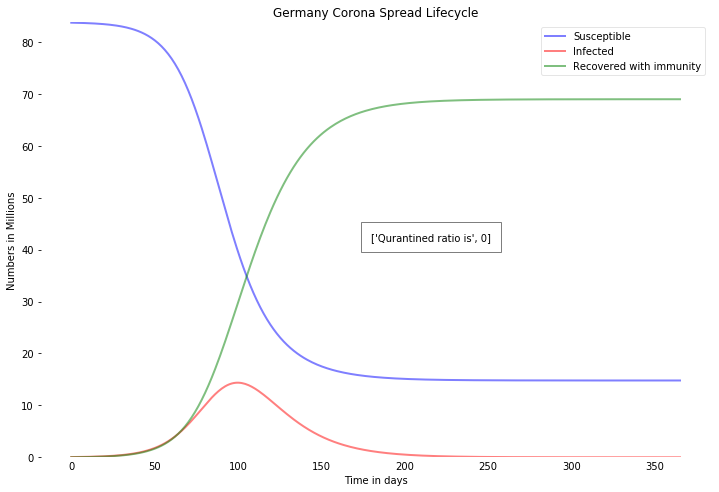

Qurantine ratio :  0.25

Infection Rate =  0.14412039468242974      Recovery Rrate =  0.06846249669072248
Reproduction rate(R0) =  2.11


<Figure size 432x288 with 0 Axes>

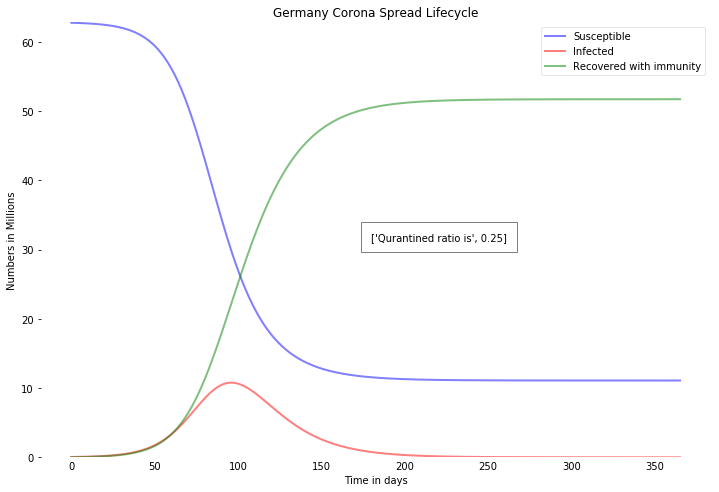

Qurantine ratio :  0.5

Infection Rate =  0.14412039468242974      Recovery Rrate =  0.06846249669072248
Reproduction rate(R0) =  2.11


<Figure size 432x288 with 0 Axes>

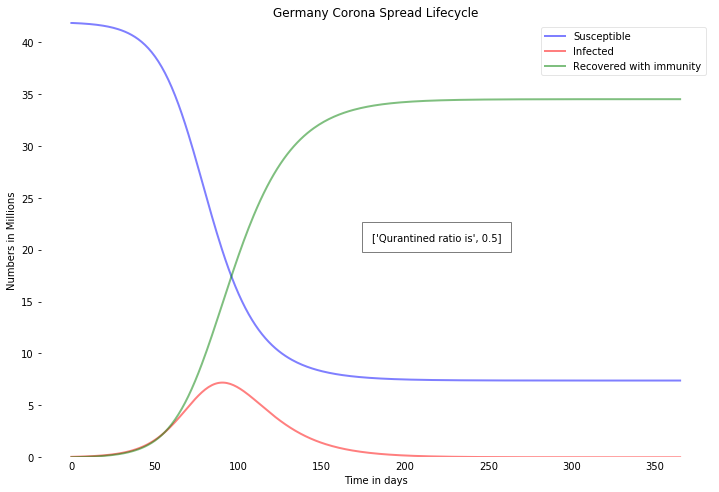

Qurantine ratio :  0.75

Infection Rate =  0.14412039468242974      Recovery Rrate =  0.06846249669072248
Reproduction rate(R0) =  2.11


<Figure size 432x288 with 0 Axes>

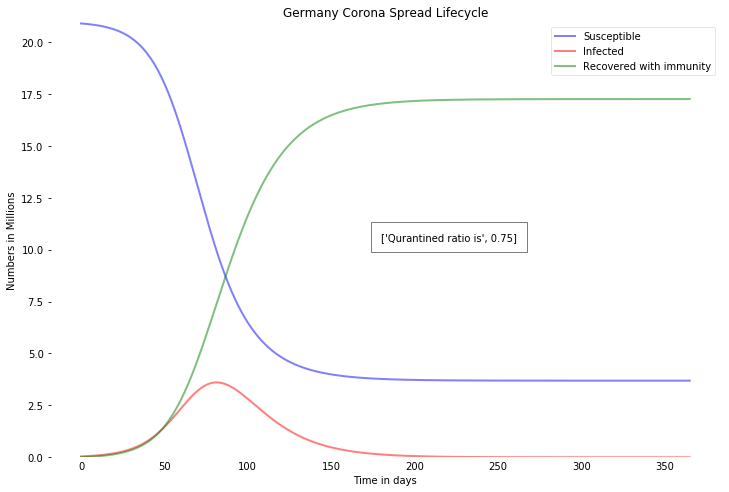

Qurantine ratio :  0.9

Infection Rate =  0.14412039468242974      Recovery Rrate =  0.06846249669072248
Reproduction rate(R0) =  2.11


<Figure size 432x288 with 0 Axes>

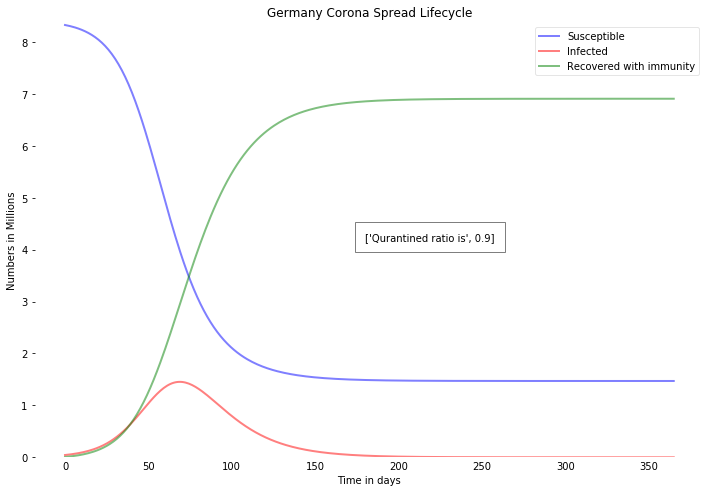

Italy
Qurantine ratio :  0

Infection Rate =  0.09119125394375527      Recovery Rrate =  0.12068619552156849
Reproduction rate(R0) =  0.76


<Figure size 432x288 with 0 Axes>

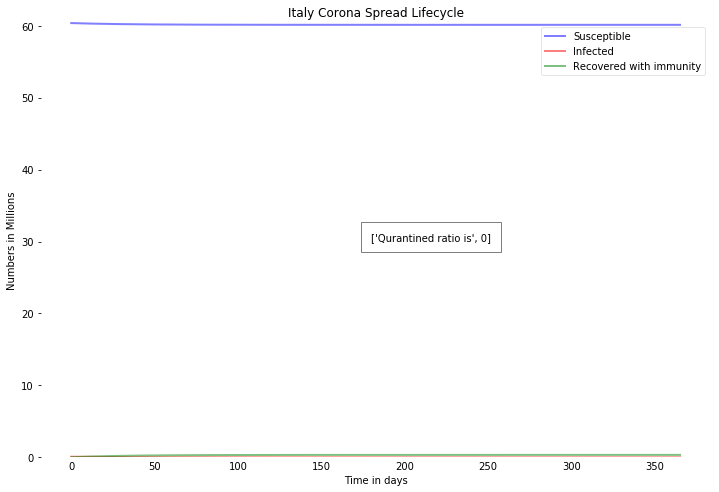

Qurantine ratio :  0.25

Infection Rate =  0.09119125394375527      Recovery Rrate =  0.12068619552156849
Reproduction rate(R0) =  0.76


<Figure size 432x288 with 0 Axes>

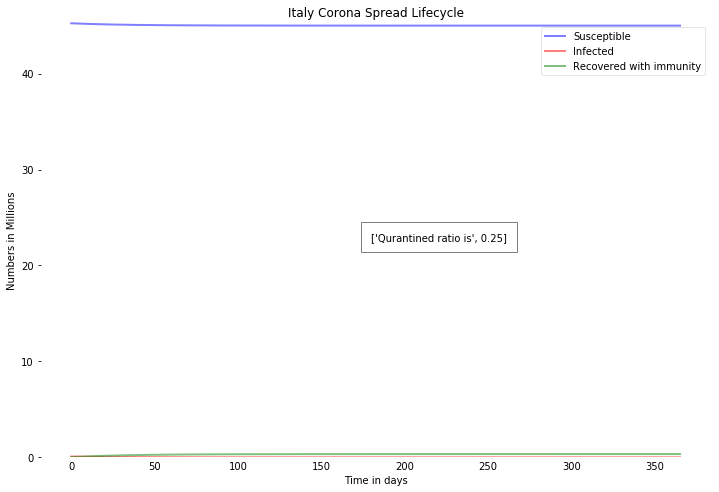

Qurantine ratio :  0.5

Infection Rate =  0.09119125394375527      Recovery Rrate =  0.12068619552156849
Reproduction rate(R0) =  0.76


<Figure size 432x288 with 0 Axes>

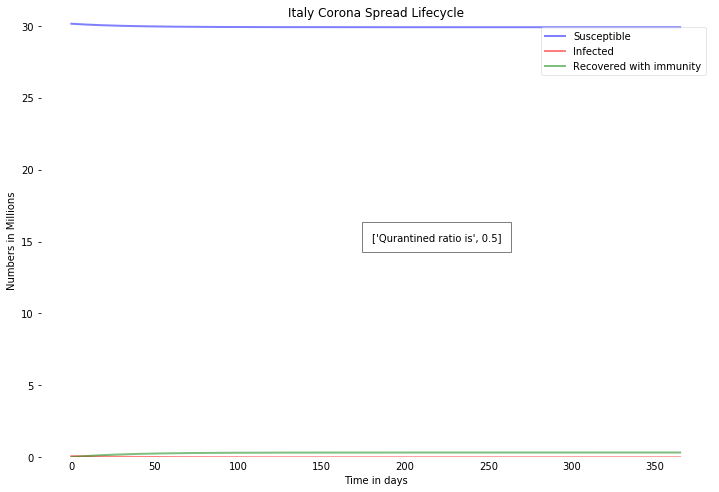

Qurantine ratio :  0.75

Infection Rate =  0.09119125394375527      Recovery Rrate =  0.12068619552156849
Reproduction rate(R0) =  0.76


<Figure size 432x288 with 0 Axes>

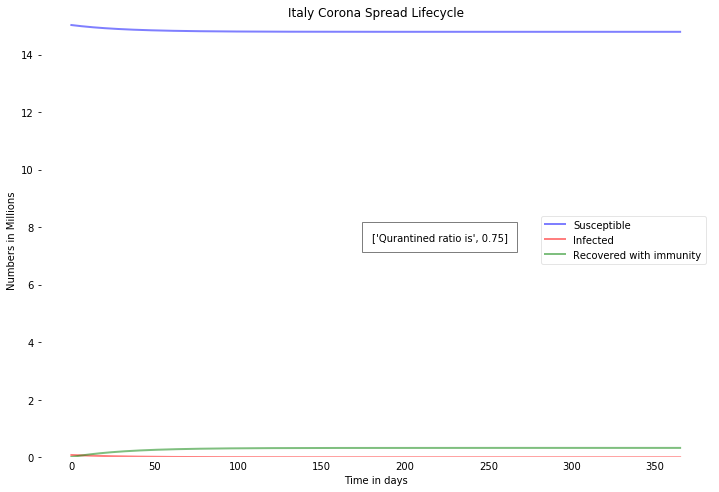

Qurantine ratio :  0.9

Infection Rate =  0.09119125394375527      Recovery Rrate =  0.12068619552156849
Reproduction rate(R0) =  0.76


<Figure size 432x288 with 0 Axes>

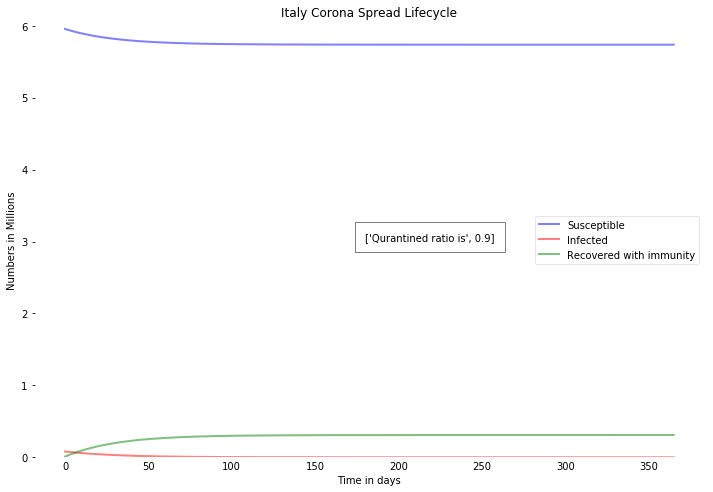

Spain
Qurantine ratio :  0

Infection Rate =  0.1827510698035899      Recovery Rrate =  0.09754137938025656
Reproduction rate(R0) =  1.87


<Figure size 432x288 with 0 Axes>

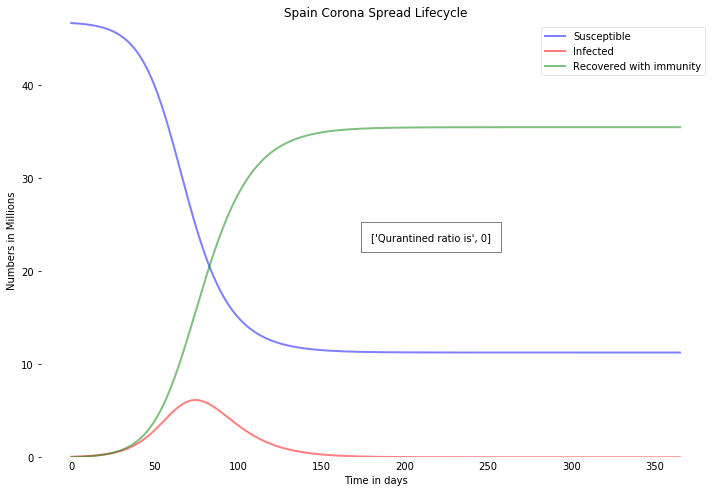

Qurantine ratio :  0.25

Infection Rate =  0.1827510698035899      Recovery Rrate =  0.09754137938025656
Reproduction rate(R0) =  1.87


<Figure size 432x288 with 0 Axes>

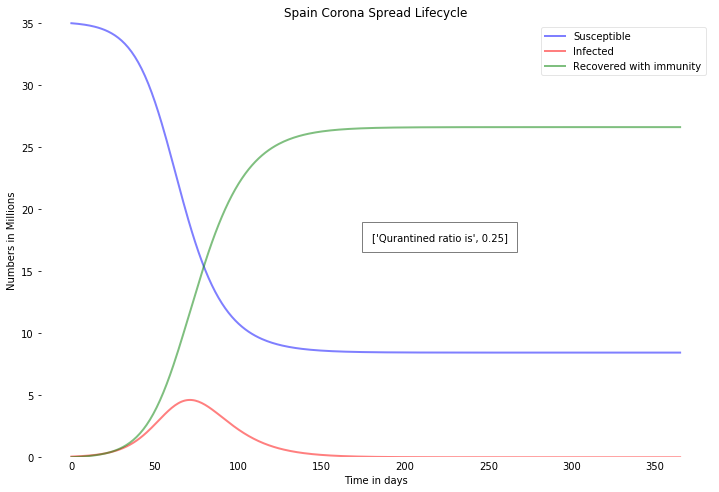

Qurantine ratio :  0.5

Infection Rate =  0.1827510698035899      Recovery Rrate =  0.09754137938025656
Reproduction rate(R0) =  1.87


<Figure size 432x288 with 0 Axes>

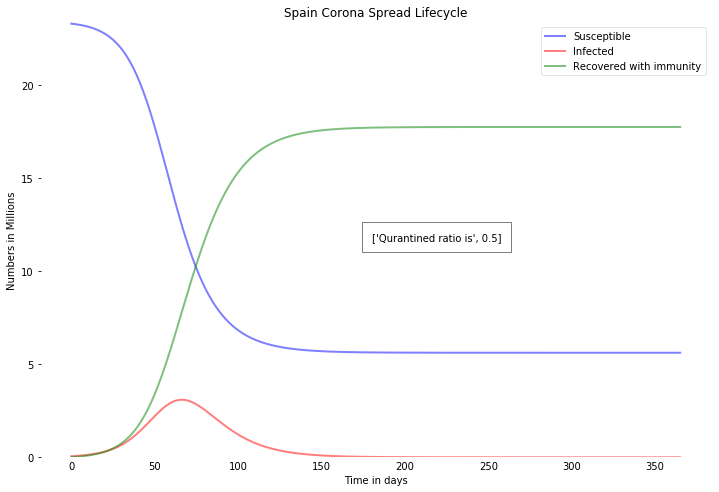

Qurantine ratio :  0.75

Infection Rate =  0.1827510698035899      Recovery Rrate =  0.09754137938025656
Reproduction rate(R0) =  1.87


<Figure size 432x288 with 0 Axes>

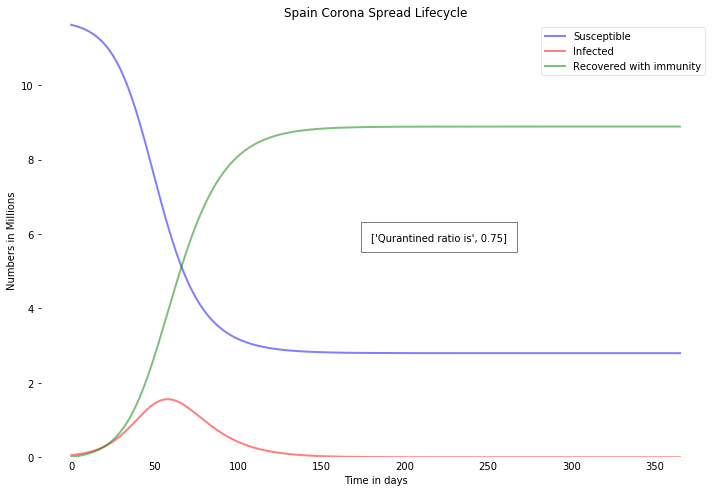

Qurantine ratio :  0.9

Infection Rate =  0.1827510698035899      Recovery Rrate =  0.09754137938025656
Reproduction rate(R0) =  1.87


<Figure size 432x288 with 0 Axes>

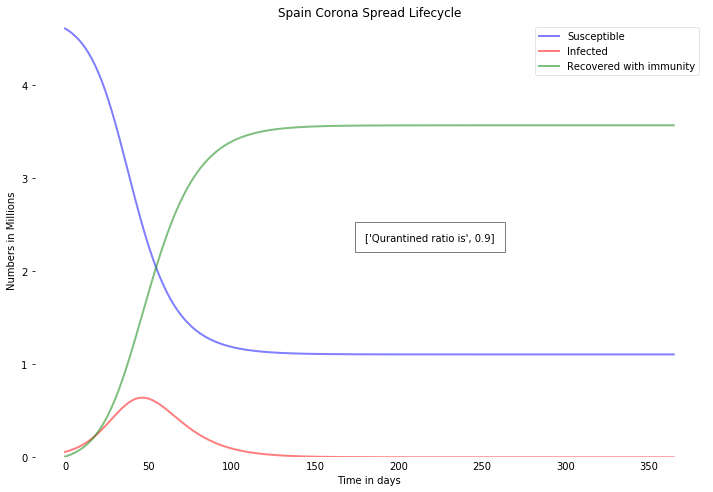

United Kingdom
Qurantine ratio :  0

Infection Rate =  0.2050149926431434      Recovery Rrate =  0.013198777506082598
Reproduction rate(R0) =  15.53


<Figure size 432x288 with 0 Axes>

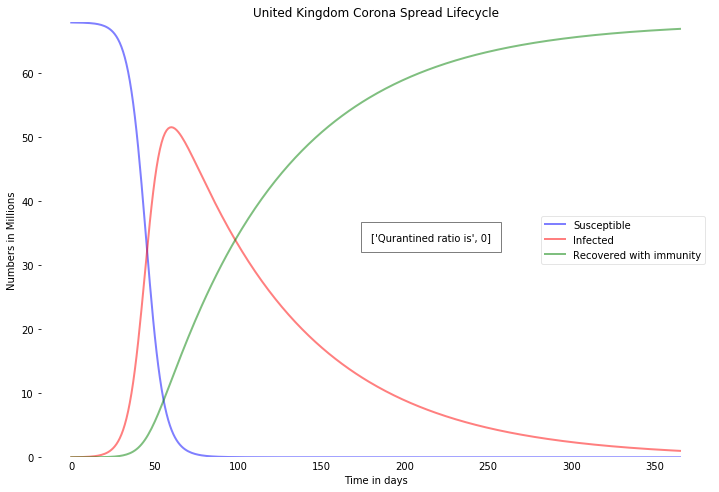

Qurantine ratio :  0.25

Infection Rate =  0.2050149926431434      Recovery Rrate =  0.013198777506082598
Reproduction rate(R0) =  15.53


<Figure size 432x288 with 0 Axes>

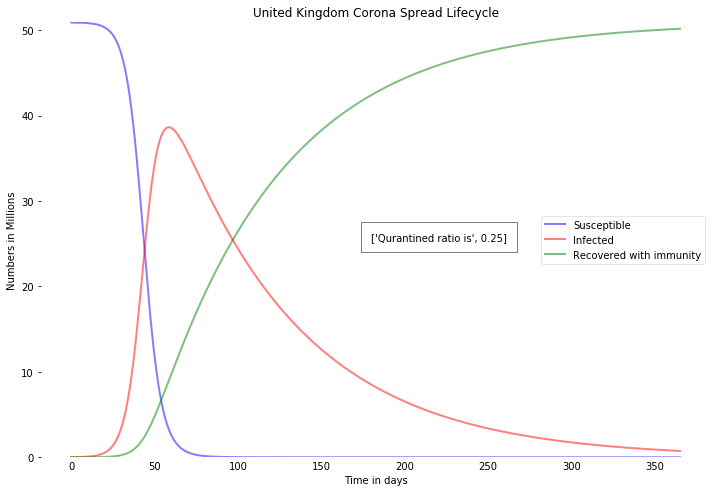

Qurantine ratio :  0.5

Infection Rate =  0.2050149926431434      Recovery Rrate =  0.013198777506082598
Reproduction rate(R0) =  15.53


<Figure size 432x288 with 0 Axes>

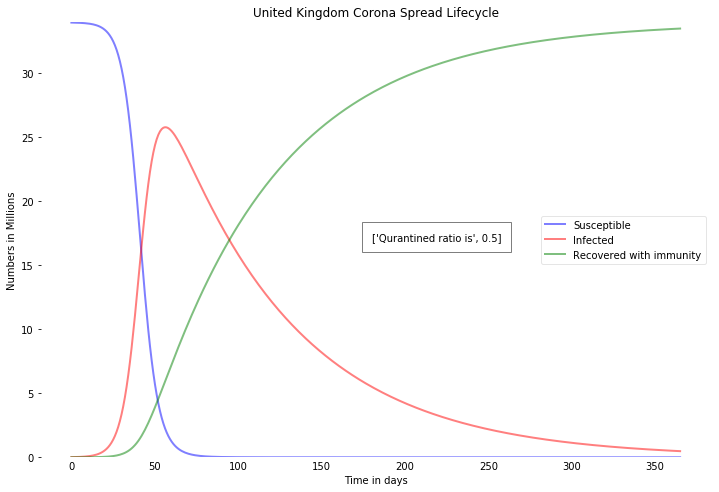

Qurantine ratio :  0.75

Infection Rate =  0.2050149926431434      Recovery Rrate =  0.013198777506082598
Reproduction rate(R0) =  15.53


<Figure size 432x288 with 0 Axes>

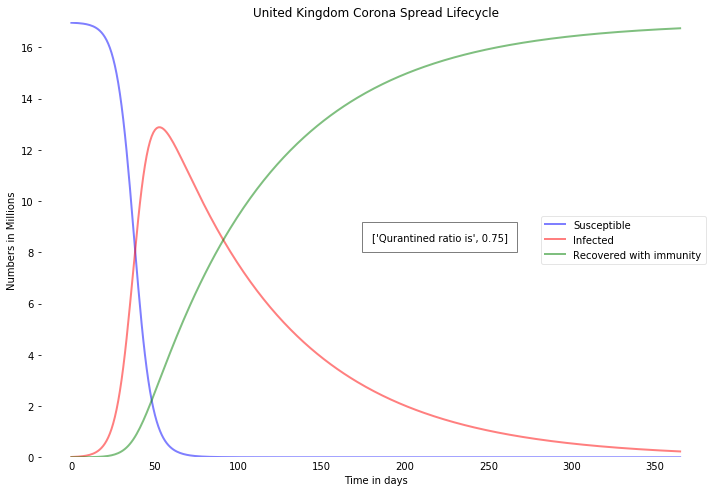

Qurantine ratio :  0.9

Infection Rate =  0.2050149926431434      Recovery Rrate =  0.013198777506082598
Reproduction rate(R0) =  15.53


<Figure size 432x288 with 0 Axes>

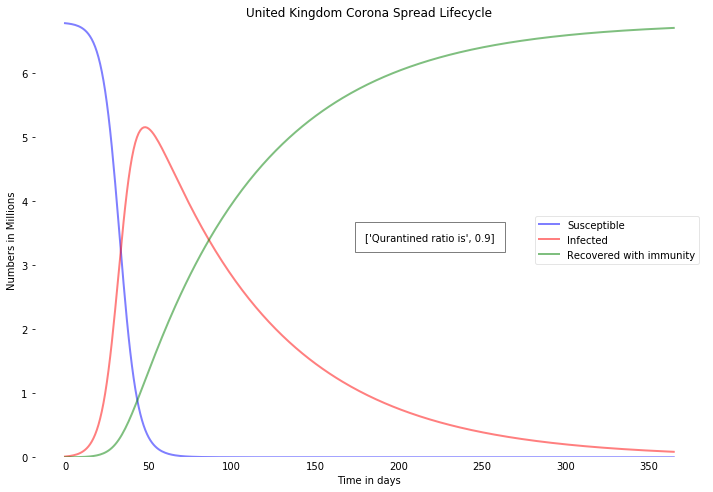

France
Qurantine ratio :  0

Infection Rate =  0.14800963856820282      Recovery Rrate =  0.1418794035862842
Reproduction rate(R0) =  1.04


<Figure size 432x288 with 0 Axes>

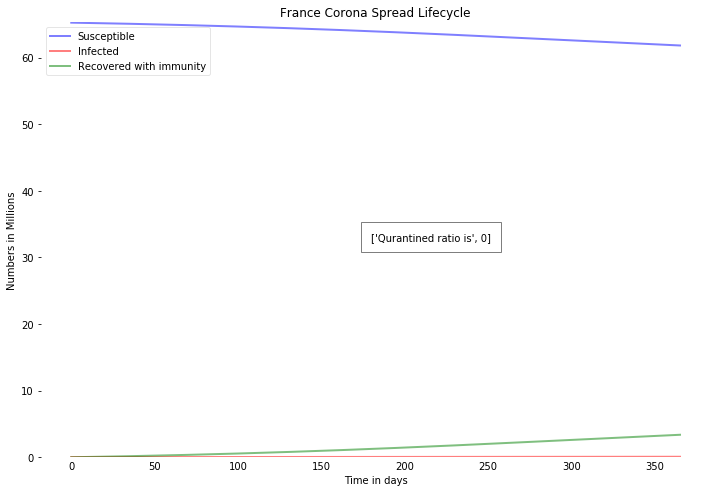

Qurantine ratio :  0.25

Infection Rate =  0.14800963856820282      Recovery Rrate =  0.1418794035862842
Reproduction rate(R0) =  1.04


<Figure size 432x288 with 0 Axes>

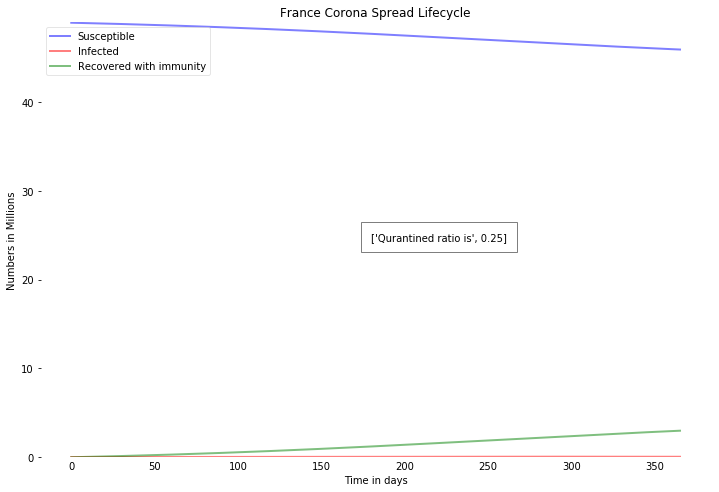

Qurantine ratio :  0.5

Infection Rate =  0.14800963856820282      Recovery Rrate =  0.1418794035862842
Reproduction rate(R0) =  1.04


<Figure size 432x288 with 0 Axes>

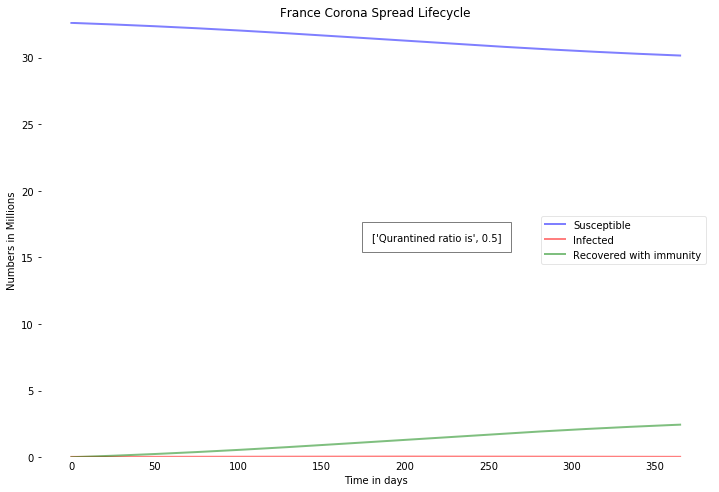

Qurantine ratio :  0.75

Infection Rate =  0.14800963856820282      Recovery Rrate =  0.1418794035862842
Reproduction rate(R0) =  1.04


<Figure size 432x288 with 0 Axes>

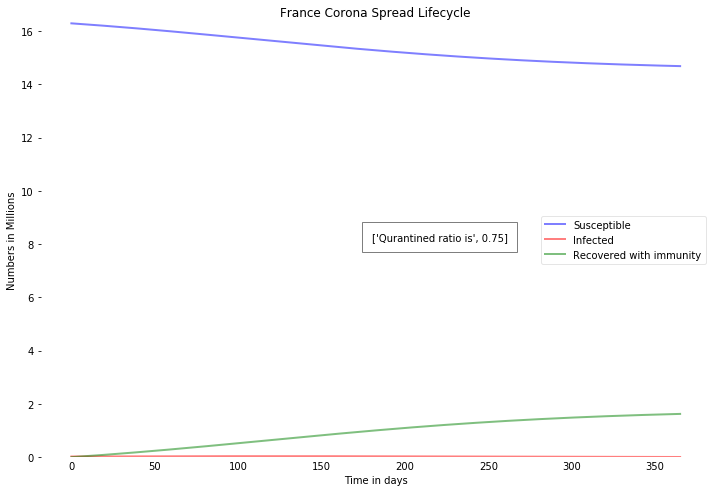

Qurantine ratio :  0.9

Infection Rate =  0.14800963856820282      Recovery Rrate =  0.1418794035862842
Reproduction rate(R0) =  1.04


<Figure size 432x288 with 0 Axes>

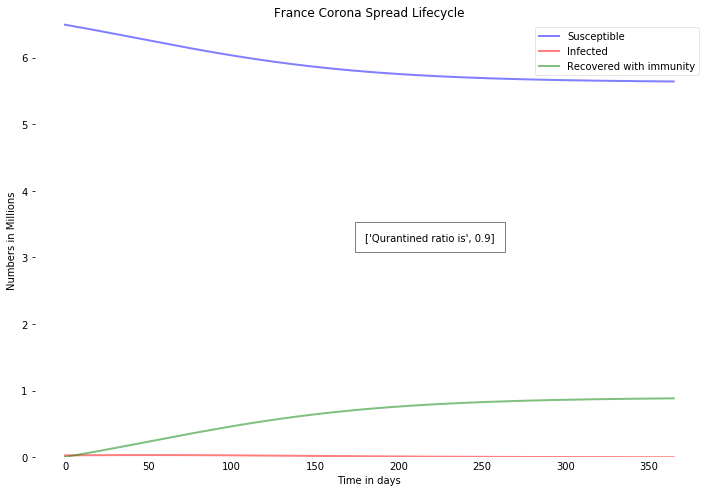

In [49]:
frac = [0, 0.25 , .5, .75, .9]
#Configuration
pp = PdfPages('D:\\backup\\Corona\\Germany new cases estimation1.pdf')

for i in c_list:
    print(i)
    for j in frac: 

        print('Qurantine ratio : ', j)

        from_date = '2020-03-26'
        qurantine_fraction = j

        df_eme_t[(df_eme_t.date == from_date)]
        from_date = datetime.strptime(from_date, '%Y-%m-%d') 
        
        rec_col_name = 'rec_'+i
        inf_ma_col_name = i+'_infection_r_ma'
        rec_ma_name = i+'_recovery_r_ma'
        
        # Initial number of infected and recovered individuals, I0 and R0.
        I0, R0 = df_eme_t[(df_eme_t.date == from_date)].at[ind, i],  df_eme_t[(df_eme_t.date == from_date)].at[ind,rec_col_name]

        print()
        # Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
        beta, gamma = df_eme_t[(df_eme_t.date == from_date)].at[ind,inf_ma_col_name],  df_eme_t[(df_eme_t.date == from_date)].at[ind,rec_ma_name]


        if i == 'US':
            i = 'United States'


        # Total population, N.
        N = df_pop[(df_pop.Country == i)].reset_index().at[0,'Population'] * (1-qurantine_fraction)


        print('Infection Rate = ', beta    , '     Recovery Rrate = ', gamma)


        print( 'Reproduction rate(R0) = ', round(beta/gamma,2))
        #adj = 1000000

        # Everyone else, S0, is susceptible to infection initially.
        S0 = N - I0 - R0

        # A grid of time points (in days)
        t = np.linspace(0, 365,365)

        # The SIR model differential equations.
        def deriv(y, t, N, beta, gamma):
            S, I, R = y
            dSdt = -beta * S * I / N
            dIdt = beta * S * I / N - gamma * I
            dRdt = gamma * I
            return dSdt, dIdt, dRdt


        # Initial conditions vector
        y0 = S0, I0, R0
        # Integrate the SIR equations over the time grid, t.
        ret = odeint(deriv, y0, t, args=(N, beta, gamma))
        S, I, R = ret.T

        # Plot the data on three separate curves for S(t), I(t) and R(t)
        fig = plt.figure(facecolor='w')
        fig = plt.figure(figsize=(12,8))

        ax = fig.add_subplot(111,  axisbelow=True)
        ax.plot(t, S/adj, 'b', alpha=0.5, lw=2, label='Susceptible')
        ax.plot(t, I/adj, 'r', alpha=0.5, lw=2, label='Infected')
        ax.plot(t, R/adj, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
        ax.set_xlabel('Time in days')
        ax.set_ylabel('Numbers in Millions')
        texts = i+' Corona Spread Lifecycle'
        ax.set_title( texts)
        texts = ['Qurantined ratio is' , qurantine_fraction]
        ax.text(180, N/2/adj,texts ,bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

        ax.set_ylim(0,N/adj)
        #ax.yaxis.set_tick_params(length=0)
        ax.xaxis.set_tick_params(length=0)
        ax.grid(b=True, which='major', c='w', lw=2, ls='-')
        legend = ax.legend()
        legend.get_frame().set_alpha(0.5)

        for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)
        plt.show()
        
        pp.savefig(fig)
pp.close()


In [ ]:
fig